In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

#def rmspe_score(y_pred,y_true):
#    return float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

#def rmspe(y_pred,dtrain):
#    labels = dtrain.get_label()
#    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/labels)**2)))


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def metrics_rmspe(y,yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_score(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=rmspe, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=rmspe)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSPE : %.4f" % rmspe_score(dtrain_predictions,dtrain[target].values))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


warnings.filterwarnings('ignore')
#Load the data from csv
store = pd.read_csv('./input/store.csv')
store_state = pd.read_csv('./input/store_states.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
store = pd.merge(store,store_state,on='Store')
display(store.info())
display(train.info())

def build_features(features):
    #features['Promo2SinceWeek'].fillna(0,inplace=True)
    #features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    #features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    #features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = features['StateHoliday'].astype(float)
    #features['StoreType'] = features['StoreType'].replace('a',1)
    #features['StoreType'] = features['StoreType'].replace('b',2)
    #features['StoreType'] = features['StoreType'].replace('c',3)
    #features['StoreType'] = features['StoreType'].replace('d',4)
    #features['StoreType'] = features['StoreType'].astype(float)
    #features['Assortment'] = features['Assortment'].replace('a',1)
    #features['Assortment'] = features['Assortment'].replace('b',2)
    #features['Assortment'] = features['Assortment'].replace('c',3)
    #features['Assortment'] = features['Assortment'].astype(float)
    #features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    #features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    AssortStore = {'aa':1,'ab':2,'ac':3,'ad':4,'ba':5,'bb':6,'bc':7,'bd':8,'ca':9,'cb':10,'cc':11,'cd':12}
    features['AssortStore'] = features['Assortment']+features['StoreType']
    features['AssortStore'] = features['AssortStore'].map(AssortStore)
    features['Date'] = pd.to_datetime(features['Date'])
    States = {'BE':1,'BW':2,'BY':3,'HB,NI':4,'HE':5,'HH':6,'NW':7,'RP':8,'SH':9,'SN':10,'ST':11,'TH':12}
    features['State'] = features['State'].map(States)
    
    features['DayOfWeekPlusState'] = features['DayOfWeek'].astype(float)+features['StateHoliday']
    features['DayOfWeekPlusSchool'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']
    #features['DayOfWeekPlusSuperHoliday'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']+features['StateHoliday']
    features['DayOfPromo'] = features['DayOfWeek'].astype(float)+(features['Promo'].astype(float)/2.0)
    features['WeekOfYear'] = features['Date'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['Date'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Day']=features['Date'].map(lambda x:x.day).astype(float)
    features['Month'] = features['Date'].map(lambda x: x.month).astype(float)
    features['Year'] = features['Date'].map(lambda x: x.year).astype(float)
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4))).astype(float)
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    features['monthStr'] = features.Month.map(month2str)
    features.loc[features.PromoInterval == 0, 'PromoInterval'] = ''
    features['IsPromoMonth'] = 0
    for interval in features.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                features.loc[(features.monthStr == month) & (features.PromoInterval == interval), 'IsPromoMonth'] = 1.0
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log(features["CompetitionDistance"]+1)
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['WeekOfYear']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features['Promo2WeekDuration'] = features.Promo2WeekDuration.apply(lambda x: x if x > 0 else 0)
    features.loc[features.Promo2SinceYear == 0, 'Promo2WeekDuration'] = 0
    
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = np.log(features["CompetitionMonthDuration"]+1)
    features["Promo2WeekDuration"] = (features["Promo2WeekDuration"]+1)
    PromoCombo = {'11':1,'10':2,'01':3,'00':4}
    features['PromoCombo'] = features['Promo'].astype(str)+features['Promo2'].astype(str)
    features['PromoCombo'] = features['PromoCombo'].map(PromoCombo)
    #features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','monthStr','Season','Assortment','StoreType','StateHoliday','Promo2','SchoolHoliday','IsPromoMonth'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

#Record Feature Building Time
feature_building_start = time.time()

store['SalesPerStore'] = np.zeros(store.Store.shape)
for i in range(1,len(store)+1):
    avg = (train[train.Store==i][train.Sales>0]['Sales']/train[train.Store==i][train.Sales>0]['Customers']).mean()
    store.set_value(store.Store==i,"SalesPerStore",avg)

org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data = org_train_data[org_train_data['Sales']>0]
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)


    
combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

combine_data = combine_data.copy()


new_combine_data = pd.DataFrame([])
min_start = 43
max_end = 44

gbm_list = []
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = combine_data[combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = combine_data[combine_data.Date>=test_start_date]

sub_range = 5
for s in range(1,sub_range+1):
    small_sample = range(s,len(store)+1,sub_range)

    org_train_sum_data = org_train_data[org_train_data.Store.isin(small_sample)]

    val_start_date = org_train_sum_data.iloc[-1].Date - timedelta(weeks=4)
    mask = (org_train_sum_data['Date'] >= val_start_date) & (org_train_sum_data['Date'] <= org_train_sum_data.iloc[-1].Date)

    #train_data, val_data = train_test_split(org_train_sum_data, test_size=0.012, random_state=10)
    #split the training data and validation data
    val_data = org_train_sum_data.loc[mask]
    train_data = org_train_sum_data.loc[~mask]
    #sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
    #train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
    #train_data = build_features(train_data)

    train_data = build_features(train_data)
    val_data = build_features(val_data)
    

    #feature_building_elapsed = time.time() - feature_building_start
    #print "Feature Building %f" % feature_building_elapsed

    #display(train_data.columns)
    #display(group.head())

    xgboost_start = time.time()


    features = [x for x in train_data.columns if x not in ['Sales']]

    dtrain = xgb.DMatrix(train_data[features], np.log(train_data["Sales"] + 1))
    dvalid = xgb.DMatrix(val_data[features], np.log(val_data["Sales"] + 1))
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.01,
              "max_depth": 9,
              "subsample": 0.3,
              "colsample_bytree": 0.8,
              "min_child_weight":8,
              "reg_alpha":1e-04,
              "seed":31,
              "silent": 1
              }
    
    num_trees = 30000
    
    res = {}
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=350, feval=rmspe, verbose_eval=False,evals_result=res)
    
    print("Validating")
    train_probs = gbm.predict(xgb.DMatrix(val_data[features]))
    indices = train_probs < 0
    train_probs[indices] = 0
    error = rmspe_score(np.exp(train_probs) - 1, val_data['Sales'].values)
    print('error', error)

    #from xgboost import XGBRegressor 
    #predictors = [x for x in train_data.columns]
    #xgbr = XGBRegressor(learning_rate=0.3,n_estimators=300,silent=1,n_jobs=8,colsample_bytree=0.6,
    #                   max_depth=6,min_child_weight=3,subsample=0.7)

    #modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')
    xgboost_train_end = time.time() - xgboost_start
    #print "XGboost Trained %f" % xgboost_train_end
    
    gbm_list.append(gbm)
    
    import operator

    _,ax = plt.subplots()
    evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
    train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
    x_axis = range(0,len(train_res))

    ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
    ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
    ax.set_title("%d Error" % small_sample[0])
    ax.set_ylim(top=0.3)
    ax.legend()
    ax.grid(True)

    plt.plot(evals_res)
    create_feature_map(train_data[features])
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

print("Make predictions on the test set")
submission = pd.DataFrame([])
for s,gbm in enumerate(gbm_list):
    small_sample = range(s+1,len(store)+1,sub_range)
    org_test_sum_data = org_test_data[org_test_data.Store.isin(small_sample)]
    test = build_features(org_test_sum_data)
    test_probs = gbm.predict(xgb.DMatrix(test[features]))
    indices = test_probs < 0
    test_probs[indices] = 0
    not_open_Id = test[test['Open']==0].index
    temp = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
    temp.set_value(not_open_Id,"Sales",0.0)
    submission = pd.concat([submission,temp],axis=0)

submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission_concat_5_4.csv", index=False)

    #org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
    #org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
    #org_test_data.sort_index(inplace=True)
    #test = build_features(org_test_data)
    #not_open_index = test[test['Open']==0].index
    #test_train = test.drop(['Id'],axis=1)
    #test_result = xgbr.predict(test_train)
    #submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
    #submission.set_value(not_open_index,"Sales",0.0)
    #submission.ix[not_open_index]["Sales"] = 0.0
    #submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
    #display(submission.ix[not_open_index])
    #submission.to_csv("my_submission.csv", index=False)



In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

#def rmspe_score(y_pred,y_true):
#    return float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

#def rmspe(y_pred,dtrain):
#    labels = dtrain.get_label()
#    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/labels)**2)))


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def metrics_rmspe(y,yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_score(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=rmspe, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=rmspe)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSPE : %.4f" % rmspe_score(dtrain_predictions,dtrain[target].values))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


warnings.filterwarnings('ignore')
#Load the data from csv
store = pd.read_csv('./input/store.csv')
store_state = pd.read_csv('./input/store_states.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
store = pd.merge(store,store_state,on='Store')
display(store.info())
display(train.info())

def build_features(features):
    #features['Promo2SinceWeek'].fillna(0,inplace=True)
    #features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    #features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    #features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = features['StateHoliday'].astype(float)
    #features['StoreType'] = features['StoreType'].replace('a',1)
    #features['StoreType'] = features['StoreType'].replace('b',2)
    #features['StoreType'] = features['StoreType'].replace('c',3)
    #features['StoreType'] = features['StoreType'].replace('d',4)
    #features['StoreType'] = features['StoreType'].astype(float)
    #features['Assortment'] = features['Assortment'].replace('a',1)
    #features['Assortment'] = features['Assortment'].replace('b',2)
    #features['Assortment'] = features['Assortment'].replace('c',3)
    #features['Assortment'] = features['Assortment'].astype(float)
    #features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    #features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    AssortStore = {'aa':1,'ab':2,'ac':3,'ad':4,'ba':5,'bb':6,'bc':7,'bd':8,'ca':9,'cb':10,'cc':11,'cd':12}
    features['AssortStore'] = features['Assortment']+features['StoreType']
    features['AssortStore'] = features['AssortStore'].map(AssortStore)
    features['Date'] = pd.to_datetime(features['Date'])
    States = {'BE':1,'BW':2,'BY':3,'HB,NI':4,'HE':5,'HH':6,'NW':7,'RP':8,'SH':9,'SN':10,'ST':11,'TH':12}
    features['State'] = features['State'].map(States)
    
    features['DayOfWeekPlusState'] = features['DayOfWeek'].astype(float)+features['StateHoliday']
    features['DayOfWeekPlusSchool'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']
    #features['DayOfWeekPlusSuperHoliday'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']+features['StateHoliday']
    features['DayOfPromo'] = features['DayOfWeek'].astype(float)+(features['Promo'].astype(float)/2.0)
    features['WeekOfYear'] = features['Date'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['Date'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Day']=features['Date'].map(lambda x:x.day).astype(float)
    features['Month'] = features['Date'].map(lambda x: x.month).astype(float)
    features['Year'] = features['Date'].map(lambda x: x.year).astype(float)
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4))).astype(float)
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    features['monthStr'] = features.Month.map(month2str)
    features.loc[features.PromoInterval == 0, 'PromoInterval'] = ''
    features['IsPromoMonth'] = 0
    for interval in features.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                features.loc[(features.monthStr == month) & (features.PromoInterval == interval), 'IsPromoMonth'] = 1.0
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log(features["CompetitionDistance"]+1)
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['WeekOfYear']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features['Promo2WeekDuration'] = features.Promo2WeekDuration.apply(lambda x: x if x > 0 else 0)
    features.loc[features.Promo2SinceYear == 0, 'Promo2WeekDuration'] = 0
    
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = np.log(features["CompetitionMonthDuration"]+1)
    features["Promo2WeekDuration"] = (features["Promo2WeekDuration"]+1)
    PromoCombo = {'11':1,'10':2,'01':3,'00':4}
    features['PromoCombo'] = features['Promo'].astype(str)+features['Promo2'].astype(str)
    features['PromoCombo'] = features['PromoCombo'].map(PromoCombo)
    #features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','monthStr','Season','Assortment','StoreType','StateHoliday','Promo2','SchoolHoliday','IsPromoMonth'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

#Record Feature Building Time
feature_building_start = time.time()

org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data = org_train_data[org_train_data['Sales']>0]
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)


    
combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

combine_data = combine_data.copy()


new_combine_data = pd.DataFrame([])
min_start = 43
max_end = 44

gbm_list = []
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = combine_data[combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = combine_data[combine_data.Date>=test_start_date]

sub_range = 10
for s in range(1,sub_range+1):
    small_sample = range(s,len(store)+1,sub_range)

    org_train_sum_data = org_train_data[org_train_data.Store.isin(small_sample)]

    val_start_date = org_train_sum_data.iloc[-1].Date - timedelta(weeks=2)
    mask = (org_train_sum_data['Date'] >= val_start_date) & (org_train_sum_data['Date'] <= org_train_sum_data.iloc[-1].Date)

    #train_data, val_data = train_test_split(org_train_sum_data, test_size=0.012, random_state=10)
    #split the training data and validation data
    val_data = org_train_sum_data.loc[mask]
    train_data = org_train_sum_data.loc[~mask]
    #sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
    #train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
    #train_data = build_features(train_data)

    train_data = build_features(train_data)
    val_data = build_features(val_data)
    

    #feature_building_elapsed = time.time() - feature_building_start
    #print "Feature Building %f" % feature_building_elapsed

    #display(train_data.columns)
    #display(group.head())

    xgboost_start = time.time()


    features = [x for x in train_data.columns if x not in ['Sales']]

    dtrain = xgb.DMatrix(train_data[features], np.log(train_data["Sales"] + 1))
    dvalid = xgb.DMatrix(val_data[features], np.log(val_data["Sales"] + 1))
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.01,
              "max_depth": 9,
              "subsample": 0.3,
              "colsample_bytree": 0.9,
              "min_child_weight":8,
              "reg_alpha":1e-04,
              "seed":31,
              "silent": 1
              }
    
    num_trees = 30000
    
    res = {}
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=350, feval=rmspe, verbose_eval=False,evals_result=res)
    
    print("Validating")
    train_probs = gbm.predict(xgb.DMatrix(val_data[features]))
    indices = train_probs < 0
    train_probs[indices] = 0
    error = rmspe_score(np.exp(train_probs) - 1, val_data['Sales'].values)
    print('error', error)

    #from xgboost import XGBRegressor 
    #predictors = [x for x in train_data.columns]
    #xgbr = XGBRegressor(learning_rate=0.3,n_estimators=300,silent=1,n_jobs=8,colsample_bytree=0.6,
    #                   max_depth=6,min_child_weight=3,subsample=0.7)

    #modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')
    xgboost_train_end = time.time() - xgboost_start
    #print "XGboost Trained %f" % xgboost_train_end
    
    gbm_list.append(gbm)
    
    import operator

    _,ax = plt.subplots()
    evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
    train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
    x_axis = range(0,len(train_res))

    ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
    ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
    ax.set_title("%d Error" % small_sample[0])
    ax.set_ylim(top=0.3)
    ax.legend()
    ax.grid(True)

    plt.plot(evals_res)
    create_feature_map(train_data[features])
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

print("Make predictions on the test set")
submission = pd.DataFrame([])
for s,gbm in enumerate(gbm_list):
    small_sample = range(s+1,len(store)+1,sub_range)
    org_test_sum_data = org_test_data[org_test_data.Store.isin(small_sample)]
    test = build_features(org_test_sum_data)
    test_probs = gbm.predict(xgb.DMatrix(test[features]))
    indices = test_probs < 0
    test_probs[indices] = 0
    not_open_Id = test[test['Open']==0].index
    temp = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
    temp.set_value(not_open_Id,"Sales",0.0)
    submission = pd.concat([submission,temp],axis=0)

submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission_concat_10_2.csv", index=False)

    #org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
    #org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
    #org_test_data.sort_index(inplace=True)
    #test = build_features(org_test_data)
    #not_open_index = test[test['Open']==0].index
    #test_train = test.drop(['Id'],axis=1)
    #test_result = xgbr.predict(test_train)
    #submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
    #submission.set_value(not_open_index,"Sales",0.0)
    #submission.ix[not_open_index]["Sales"] = 0.0
    #submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
    #display(submission.ix[not_open_index])
    #submission.to_csv("my_submission.csv", index=False)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 11 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
State                        1115 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 104.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

Validating
('error', 0.11009655223338254)
Validating
('error', 0.10092597243488335)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

#def rmspe_score(y_pred,y_true):
#    return float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

#def rmspe(y_pred,dtrain):
#    labels = dtrain.get_label()
#    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/labels)**2)))


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def metrics_rmspe(y,yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_score(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=rmspe, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=rmspe)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSPE : %.4f" % rmspe_score(dtrain_predictions,dtrain[target].values))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


warnings.filterwarnings('ignore')
#Load the data from csv
store = pd.read_csv('./input/store.csv')
store_state = pd.read_csv('./input/store_states.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
store = pd.merge(store,store_state,on='Store')
display(store.info())
display(train.info())

def build_features(features):
    #features['Promo2SinceWeek'].fillna(0,inplace=True)
    #features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    #features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    #features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = features['StateHoliday'].astype(float)
    #features['StoreType'] = features['StoreType'].replace('a',1)
    #features['StoreType'] = features['StoreType'].replace('b',2)
    #features['StoreType'] = features['StoreType'].replace('c',3)
    #features['StoreType'] = features['StoreType'].replace('d',4)
    #features['StoreType'] = features['StoreType'].astype(float)
    #features['Assortment'] = features['Assortment'].replace('a',1)
    #features['Assortment'] = features['Assortment'].replace('b',2)
    #features['Assortment'] = features['Assortment'].replace('c',3)
    #features['Assortment'] = features['Assortment'].astype(float)
    #features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    #features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    AssortStore = {'aa':1,'ab':2,'ac':3,'ad':4,'ba':5,'bb':6,'bc':7,'bd':8,'ca':9,'cb':10,'cc':11,'cd':12}
    features['AssortStore'] = features['Assortment']+features['StoreType']
    features['AssortStore'] = features['AssortStore'].map(AssortStore)
    features['Date'] = pd.to_datetime(features['Date'])
    States = {'BE':1,'BW':2,'BY':3,'HB,NI':4,'HE':5,'HH':6,'NW':7,'RP':8,'SH':9,'SN':10,'ST':11,'TH':12}
    features['State'] = features['State'].map(States)
    
    features['DayOfWeekPlusState'] = features['DayOfWeek'].astype(float)+features['StateHoliday']
    features['DayOfWeekPlusSchool'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']
    #features['DayOfWeekPlusSuperHoliday'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']+features['StateHoliday']
    features['DayOfPromo'] = features['DayOfWeek'].astype(float)+(features['Promo'].astype(float)/2.0)
    features['WeekOfYear'] = features['Date'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['Date'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Day']=features['Date'].map(lambda x:x.day).astype(float)
    features['Month'] = features['Date'].map(lambda x: x.month).astype(float)
    features['Year'] = features['Date'].map(lambda x: x.year).astype(float)
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4))).astype(float)
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    features['monthStr'] = features.Month.map(month2str)
    features.loc[features.PromoInterval == 0, 'PromoInterval'] = ''
    features['IsPromoMonth'] = 0
    for interval in features.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                features.loc[(features.monthStr == month) & (features.PromoInterval == interval), 'IsPromoMonth'] = 1.0
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log(features["CompetitionDistance"]+1)
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['WeekOfYear']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features['Promo2WeekDuration'] = features.Promo2WeekDuration.apply(lambda x: x if x > 0 else 0)
    features.loc[features.Promo2SinceYear == 0, 'Promo2WeekDuration'] = 0
    
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = np.log(features["CompetitionMonthDuration"]+1)
    features["Promo2WeekDuration"] = (features["Promo2WeekDuration"]+1)
    PromoCombo = {'11':1,'10':2,'01':3,'00':4}
    features['PromoCombo'] = features['Promo'].astype(str)+features['Promo2'].astype(str)
    features['PromoCombo'] = features['PromoCombo'].map(PromoCombo)
    #features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','monthStr','Season','Assortment','StoreType','StateHoliday','Promo2','SchoolHoliday','IsPromoMonth'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

#Record Feature Building Time
feature_building_start = time.time()

org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data = org_train_data[org_train_data['Sales']>0]
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)


    
combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

combine_data = combine_data.copy()


new_combine_data = pd.DataFrame([])
min_start = 43
max_end = 44

gbm_list = []
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = combine_data[combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = combine_data[combine_data.Date>=test_start_date]

sub_range = 5
for s in range(1,sub_range+1):
    small_sample = range(s,len(store)+1,sub_range)

    org_train_sum_data = org_train_data[org_train_data.Store.isin(small_sample)]

    val_start_date = org_train_sum_data.iloc[-1].Date - timedelta(weeks=4)
    mask = (org_train_sum_data['Date'] >= val_start_date) & (org_train_sum_data['Date'] <= org_train_sum_data.iloc[-1].Date)

    #train_data, val_data = train_test_split(org_train_sum_data, test_size=0.012, random_state=10)
    #split the training data and validation data
    val_data = org_train_sum_data.loc[mask]
    train_data = org_train_sum_data.loc[~mask]
    #sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
    #train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
    #train_data = build_features(train_data)

    train_data = build_features(train_data)
    val_data = build_features(val_data)
    

    #feature_building_elapsed = time.time() - feature_building_start
    #print "Feature Building %f" % feature_building_elapsed

    #display(train_data.columns)
    #display(group.head())

    xgboost_start = time.time()


    features = [x for x in train_data.columns if x not in ['Sales']]

    dtrain = xgb.DMatrix(train_data[features], np.log(train_data["Sales"] + 1))
    dvalid = xgb.DMatrix(val_data[features], np.log(val_data["Sales"] + 1))
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.01,
              "max_depth": 9,
              "subsample": 0.3,
              "colsample_bytree": 0.8,
              "min_child_weight":8,
              "reg_alpha":1e-04,
              "seed":31,
              "silent": 1
              }
    
    num_trees = 30000
    
    res = {}
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=350, feval=rmspe, verbose_eval=False,evals_result=res)
    
    print("Validating")
    train_probs = gbm.predict(xgb.DMatrix(val_data[features]))
    indices = train_probs < 0
    train_probs[indices] = 0
    error = rmspe_score(np.exp(train_probs) - 1, val_data['Sales'].values)
    print('error', error)

    #from xgboost import XGBRegressor 
    #predictors = [x for x in train_data.columns]
    #xgbr = XGBRegressor(learning_rate=0.3,n_estimators=300,silent=1,n_jobs=8,colsample_bytree=0.6,
    #                   max_depth=6,min_child_weight=3,subsample=0.7)

    #modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')
    xgboost_train_end = time.time() - xgboost_start
    #print "XGboost Trained %f" % xgboost_train_end
    
    gbm_list.append(gbm)
    
    import operator

    _,ax = plt.subplots()
    evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
    train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
    x_axis = range(0,len(train_res))

    ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
    ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
    ax.set_title("%d Error" % small_sample[0])
    ax.set_ylim(top=0.3)
    ax.legend()
    ax.grid(True)

    plt.plot(evals_res)
    create_feature_map(train_data[features])
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

print("Make predictions on the test set")
submission = pd.DataFrame([])
for s,gbm in enumerate(gbm_list):
    small_sample = range(s+1,len(store)+1,sub_range)
    org_test_sum_data = org_test_data[org_test_data.Store.isin(small_sample)]
    test = build_features(org_test_sum_data)
    test_probs = gbm.predict(xgb.DMatrix(test[features]))
    indices = test_probs < 0
    test_probs[indices] = 0
    not_open_Id = test[test['Open']==0].index
    temp = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
    temp.set_value(not_open_Id,"Sales",0.0)
    submission = pd.concat([submission,temp],axis=0)

submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission_concat_5_4.csv", index=False)

    #org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
    #org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
    #org_test_data.sort_index(inplace=True)
    #test = build_features(org_test_data)
    #not_open_index = test[test['Open']==0].index
    #test_train = test.drop(['Id'],axis=1)
    #test_result = xgbr.predict(test_train)
    #submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
    #submission.set_value(not_open_index,"Sales",0.0)
    #submission.ix[not_open_index]["Sales"] = 0.0
    #submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
    #display(submission.ix[not_open_index])
    #submission.to_csv("my_submission.csv", index=False)

#

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 11 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
State                        1115 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 104.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

Validating
('error', 0.11801332341059187)
Validating
('error', 0.13201117018339129)
Validating
('error', 0.11253462864596779)
Validating
('error', 0.11379416494294904)
Validating
('error', 0.10897284075754299)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 11 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
State                        1115 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 104.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

Assortment  CompetitionDistance  DayOfWeek  Open  Promo  \
Date       Store                                                            
2013-01-01 85            1.0             7.534228          2   1.0      0   
           259           2.0             5.351858          2   1.0      0   
           262           1.0             7.074117          2   1.0      0   
           274           2.0             8.200014          2   1.0      0   
           335           1.0             4.510860          2   1.0      0   

                  Promo2    Sales  SalesPerStore  SchoolHoliday  StateHoliday  \
Date       Store                                                                
2013-01-01 85          0   4220.0       7.119747              1           1.0   
           259         0   6851.0       4.884189              1           1.0   
           262         0  17267.0       6.057073              1           1.0   
           274         1   3102.0       4.035350              1           1.0   
           335         1   2401.0       5.500066              1           1.0   

                     ...      WeekOfYear  DayOfYear  Day  Month    Year  \
Date       Store     ...                                                  
2013-01-01 85        ...             1.0        1.0  1.0    1.0  2013.0   
           259       ...             1.0        1.0  1.0    1.0  2013.0   
           262       ...             1.0        1.0  1.0    1.0  2013.0   
           274       ...             1.0        1.0  1.0    1.0  2013.0   
           335       ...             1.0        1.0  1.0    1.0  2013.0   

                  Season  IsPromoMonth  CompetitionMonthDuration  \
Date       Store                                                   
2013-01-01 85        1.0           0.0                      16.0   
           259       1.0           0.0                       1.0   
           262       1.0           0.0                      -3.0   
           274       1.0           1.0                       1.0   
           335       1.0           1.0                       1.0   

                  Promo2WeekDuration  PromoCombo  
Date       Store                                  
2013-01-01 85                    1.0           4  
           259                   1.0           4  
           262                   1.0           4  
           274                   1.0           3  
           335                   1.0           3  

[5 rows x 26 columns]

Validating
('error', 0.12150717876178377)
Make predictions on the test set


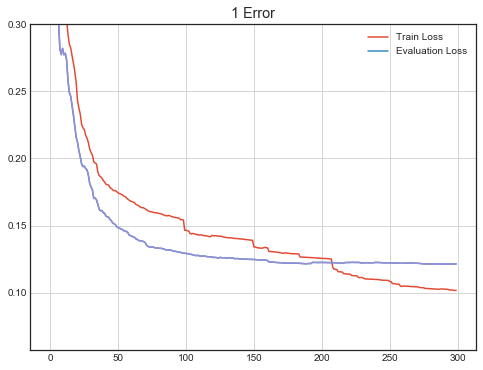

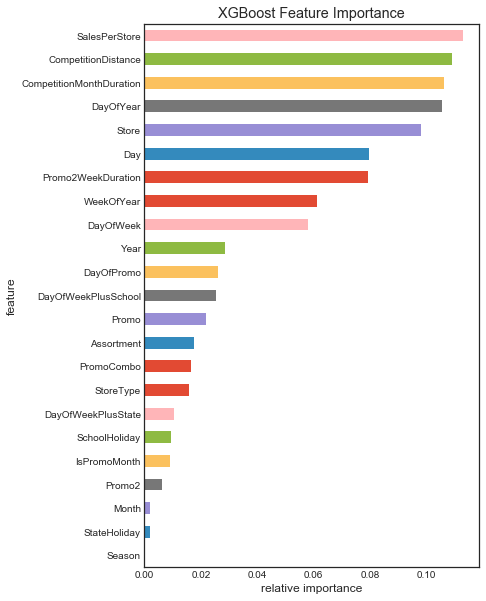

In [4]:
#Original Test

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

#def rmspe_score(y_pred,y_true):
#    return float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

#def rmspe(y_pred,dtrain):
#    labels = dtrain.get_label()
#    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/labels)**2)))


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def metrics_rmspe(y,yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_score(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=rmspe, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=rmspe)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSPE : %.4f" % rmspe_score(dtrain_predictions,dtrain[target].values))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


warnings.filterwarnings('ignore')
#Load the data from csv
store = pd.read_csv('./input/store.csv')
store_state = pd.read_csv('./input/store_states.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
store = pd.merge(store,store_state,on='Store')
display(store.info())
display(train.info())

def build_features(features):
    #features['Promo2SinceWeek'].fillna(0,inplace=True)
    #features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    #features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    #features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = features['StateHoliday'].astype(float)
    features['StoreType'] = features['StoreType'].replace('a',1)
    features['StoreType'] = features['StoreType'].replace('b',2)
    features['StoreType'] = features['StoreType'].replace('c',3)
    features['StoreType'] = features['StoreType'].replace('d',4)
    features['StoreType'] = features['StoreType'].astype(float)
    features['Assortment'] = features['Assortment'].replace('a',1)
    features['Assortment'] = features['Assortment'].replace('b',2)
    features['Assortment'] = features['Assortment'].replace('c',3)
    features['Assortment'] = features['Assortment'].astype(float)
    #features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    #features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    AssortStore = {'aa':1,'ab':2,'ac':3,'ad':4,'ba':5,'bb':6,'bc':7,'bd':8,'ca':9,'cb':10,'cc':11,'cd':12}
    features['AssortStore'] = features['Assortment']+features['StoreType']
    features['AssortStore'] = features['AssortStore'].map(AssortStore)
    features['Date'] = pd.to_datetime(features['Date'])
    
    features['DayOfWeekPlusState'] = features['DayOfWeek'].astype(float)+features['StateHoliday']
    features['DayOfWeekPlusSchool'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']
    #features['DayOfWeekPlusSuperHoliday'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']+features['StateHoliday']
    features['DayOfPromo'] = features['DayOfWeek'].astype(float)+(features['Promo'].astype(float)/2.0)
    features['WeekOfYear'] = features['Date'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['Date'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Day']=features['Date'].map(lambda x:x.day).astype(float)
    features['Month'] = features['Date'].map(lambda x: x.month).astype(float)
    features['Year'] = features['Date'].map(lambda x: x.year).astype(float)
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4))).astype(float)
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    features['monthStr'] = features.Month.map(month2str)
    features.loc[features.PromoInterval == 0, 'PromoInterval'] = ''
    features['IsPromoMonth'] = 0
    for interval in features.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                features.loc[(features.monthStr == month) & (features.PromoInterval == interval), 'IsPromoMonth'] = 1.0
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log(features["CompetitionDistance"]+1)
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['WeekOfYear']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features['Promo2WeekDuration'] = features.Promo2WeekDuration.apply(lambda x: x if x > 0 else 0)
    features.loc[features.Promo2SinceYear == 0, 'Promo2WeekDuration'] = 0
    
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = (features["CompetitionMonthDuration"]+1)
    features["Promo2WeekDuration"] = (features["Promo2WeekDuration"]+1)
    PromoCombo = {'11':1,'10':2,'01':3,'00':4}
    features['PromoCombo'] = features['Promo'].astype(str)+features['Promo2'].astype(str)
    features['PromoCombo'] = features['PromoCombo'].map(PromoCombo)
    #features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','monthStr','State'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

#Record Feature Building Time
feature_building_start = time.time()

store['SalesPerStore'] = np.zeros(store.Store.shape)
for i in range(1,len(store)+1):
    avg = (train[train.Store==i][train.Sales>0]['Sales']/train[train.Store==i][train.Sales>0]['Customers']).mean()
    store.set_value(store.Store==i,"SalesPerStore",avg)

org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data = org_train_data[org_train_data['Sales']>0]
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)


    
combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

combine_data = combine_data.copy()


new_combine_data = pd.DataFrame([])
min_start = 43
max_end = 44

gbm_list = []
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = combine_data[combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = combine_data[combine_data.Date>=test_start_date]

sub_range = 1
for s in range(1,sub_range+1):
    small_sample = range(s,len(store)+1,sub_range)

    org_train_sum_data = org_train_data[org_train_data.Store.isin(small_sample)]

    val_start_date = org_train_sum_data.iloc[-1].Date - timedelta(weeks=2)
    mask = (org_train_sum_data['Date'] >= val_start_date) & (org_train_sum_data['Date'] <= org_train_sum_data.iloc[-1].Date)

    #train_data, val_data = train_test_split(org_train_sum_data, test_size=0.012, random_state=10)
    #split the training data and validation data
    val_data = org_train_sum_data.loc[mask]
    train_data = org_train_sum_data.loc[~mask]
    #sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
    #train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
    #train_data = build_features(train_data)

    train_data = build_features(train_data)
    val_data = build_features(val_data)
    
    display(train_data.head())
    

    #feature_building_elapsed = time.time() - feature_building_start
    #print "Feature Building %f" % feature_building_elapsed

    #display(train_data.columns)
    #display(group.head())

    xgboost_start = time.time()


    features = [x for x in train_data.columns if x not in ['Sales']]

    dtrain = xgb.DMatrix(train_data[features], np.log(train_data["Sales"] + 1))
    dvalid = xgb.DMatrix(val_data[features], np.log(val_data["Sales"] + 1))
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.4,
              "max_depth": 9,
              "subsample": 0.4,
              "colsample_bytree": 0.9,
              "min_child_weight":8,
              "reg_alpha":1e-04,
              "seed":31,
              "silent": 1
              }
    
    num_trees = 300
    
    res = {}
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe, verbose_eval=True,evals_result=res)
    
    print("Validating")
    train_probs = gbm.predict(xgb.DMatrix(val_data[features]))
    indices = train_probs < 0
    train_probs[indices] = 0
    error = rmspe_score(np.exp(train_probs) - 1, val_data['Sales'].values)
    print('error', error)

    #from xgboost import XGBRegressor 
    #predictors = [x for x in train_data.columns]
    #xgbr = XGBRegressor(learning_rate=0.3,n_estimators=300,silent=1,n_jobs=8,colsample_bytree=0.6,
    #                   max_depth=6,min_child_weight=3,subsample=0.7)

    #modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')
    xgboost_train_end = time.time() - xgboost_start
    #print "XGboost Trained %f" % xgboost_train_end
    
    gbm_list.append(gbm)
    
    import operator

    _,ax = plt.subplots()
    evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
    train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
    x_axis = range(0,len(train_res))

    ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
    ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
    ax.set_title("%d Error" % small_sample[0])
    ax.set_ylim(top=0.3)
    ax.legend()
    ax.grid(True)

    plt.plot(evals_res)
    create_feature_map(train_data[features])
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

print("Make predictions on the test set")
submission = pd.DataFrame([])
for s,gbm in enumerate(gbm_list):
    small_sample = range(s+1,len(store)+1,sub_range)
    org_test_sum_data = org_test_data[org_test_data.Store.isin(small_sample)]
    test = build_features(org_test_sum_data)
    test_probs = gbm.predict(xgb.DMatrix(test[features]))
    indices = test_probs < 0
    test_probs[indices] = 0
    not_open_Id = test[test['Open']==0].index
    temp = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
    temp.set_value(not_open_Id,"Sales",0.0)
    submission = pd.concat([submission,temp],axis=0)

submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission_concat_1_2.csv", index=False)

    #org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
    #org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
    #org_test_data.sort_index(inplace=True)
    #test = build_features(org_test_data)
    #not_open_index = test[test['Open']==0].index
    #test_train = test.drop(['Id'],axis=1)
    #test_result = xgbr.predict(test_train)
    #submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
    #submission.set_value(not_open_index,"Sales",0.0)
    #submission.ix[not_open_index]["Sales"] = 0.0
    #submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
    #display(submission.ix[not_open_index])
    #submission.to_csv("my_submission.csv", index=False)

